In [10]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

input_folder = r'C:\Users\91969\Desktop\Fake Currency  Detection11\dataset\fake'  

datagen = ImageDataGenerator(
    rotation_range=40,            
    width_shift_range=0.2,        
    height_shift_range=0.2,      
    shear_range=0.2,              
    zoom_range=0.2,               
    horizontal_flip=True,         
    fill_mode='nearest'           
)

for img_name in os.listdir(input_folder):
    if img_name.endswith(('.jpg', '.jpeg', '.png')):  
        img_path = os.path.join(input_folder, img_name)
        img = load_img(img_path)  
        x = img_to_array(img)     
        x = np.expand_dims(x, axis=0)  

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=input_folder, save_prefix='aug_', save_format='jpg'):
            i += 1
            if i >= 10:  
                break


In [15]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image  

img_size = (256, 256)  
real_folder = r'C:\Users\91969\Desktop\Fake Currency  Detection11\dataset\real' 
fake_folder = r'C:\Users\91969\Desktop\Fake Currency  Detection11\dataset\fake'  

def load_images_from_folder(folder, label, img_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  
            img_array = np.expand_dims(img_array, axis=-1)  
            images.append(img_array)
            labels.append(label)  
    return np.array(images), np.array(labels)

real_images, real_labels = load_images_from_folder(real_folder, 0, img_size) 
fake_images, fake_labels = load_images_from_folder(fake_folder, 1, img_size)  

X = np.concatenate((real_images, fake_images), axis=0)
y = np.concatenate((real_labels, fake_labels), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")



Training data shape: (208, 256, 256, 1), Training labels shape: (208,)
Testing data shape: (52, 256, 256, 1), Testing labels shape: (52,)


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (256, 256, 1) 

def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))  

    return model

model = create_cnn_model(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

model.save('fake_currency_detector.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,529 (56.60 MB)

 Trainable params: 14,838,529 (56.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4992 - loss: 2.0512 - val_accuracy: 0.5769 - val_loss: 0.6622
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 977ms/step - accuracy: 0.6790 - loss: 0.6498 - val_accuracy: 0.7308 - val_loss: 0.4388
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 988ms/step - accuracy: 0.7821 - loss: 0.4283 - val_accuracy: 0.9615 - val_loss: 0.1739
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 982ms/step - accuracy: 0.9326 - loss: 0.2483 - val_accuracy: 0.8269 - val_loss: 0.2807
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 977ms/step - accuracy: 0.8862 - loss: 0.3518 - val_accuracy: 0.9615 - val_loss: 0.1530
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 985ms/step - accuracy: 0.9522 - loss: 0.1666 - val_accuracy: 0.9808 - val_loss: 0.0698
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 982ms/step - accuracy: 0.9642 - loss: 0.1644 - val_accuracy: 1.0000 - val_loss: 0.0717
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 999ms/step - accuracy: 0.9734 - loss: 0.0796 - val_accuracy: 0.9423 - val_loss: 0

Test Accuracy: 0.9231


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


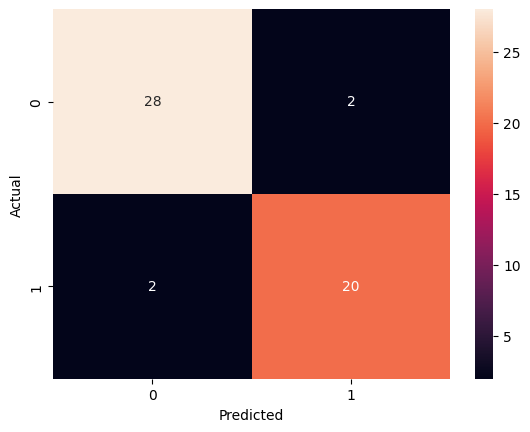

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [27]:
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)
for i in range(5):
    print(f"True label: {y_test[i]}, Predicted label: {y_pred_labels[i]}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]


In [1]:
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\91969\Desktop\Fake Currency  Detection11\fake_currency_detector.h5')

In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size, color_mode='grayscale')
    img = img_to_array(img) / 255.0
    return np.expand_dims(img, axis=0)
new_image = preprocess_image(r"C:\Users\91969\Desktop\Fake Currency Detection10\500\61.png")

In [15]:
prediction = model.predict(new_image)
predicted_class = 'Fake' if prediction > 0.5 else 'Real'
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted class: Real
